In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
from tqdm import tqdm
import GPy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import time

In [3]:
#Data class for fast testing of Gpy

class GPY_data():
    def __init__(self,pdDF,features,cell_lines):
        '''
        Class that takes in dataframe of all the cell conditions and filters for various parameters. Creates sub dataframes by filtering for
        missing gene values, missing protein values and individual chromosome level. Dataframe exists as a 3 column df, to get sub columns of
        the index use:
            #test.rna['AT2_04M_F0'].index.get_level_values(0) #selects a single index for multiindex
        
        self.cell_lines has the names of the different conditions, use that as keys to get data from:
            self.rna - (dictionary) rows of genes of nonzero mRNA levels
            self.rna_protein - (dictinary) rows of genes of nonzero mRNA and protein levels
            self.chrm - (dictionary of dictionary) top level dictionary keys are cell lines, second level down are chrm{i}, 1<=i<=21
        
        Various functions for testing gpy models, and uniform plotting:
            -grid to project back onto chrm position
            -grid 
            
        '''
        assert isinstance(pdDF,pd.DataFrame)
        assert isinstance(features, list)
        assert isinstance(cell_lines, list)
        
        self.data = pdDF.copy() #pandas dataframe
        self.data['Gene Length'] = np.log2(self.data[['Gene Length']]) #log2 of gene length
        self.features = features
        self.cell_lines = cell_lines #single list
        
        self.rna = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA levels
        self.rna_chrm = {} #Dictinoary of data frames filtered for each chromosome, contains all genes with nonzero mRNA
        self.rna_protein = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA and protein levels
        self.rna_protein_chrm = {} #Data frames filtered for each chromosome, contains only nonzero mRNA and protein
        num_chrms = 21 #accounting for both x/y chrms
        
        for cell_condition in cell_lines:
            rna_prot = [cell_condition,cell_condition+'_P'] #mRNA and protein names
            self.rna[cell_condition] = self.data[features+rna_prot][self.data[cell_condition]!=0] #removes genes where mRNA = 0
            self.rna_protein[cell_condition] = self.rna[cell_condition][self.rna[cell_condition][cell_condition+'_P']!=0] #removes genes where mRNA and protein levels are 0
            sub_rna_chrm = {}
            sub_chrm = {}
            for i in range(num_chrms):
                sub_rna_chrm[f'chrm{i+1}'] = self.rna[cell_condition][(self.rna[cell_condition]['AvgChrs']>=i) & (self.rna[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
                sub_chrm[f'chrm{i+1}'] = self.rna_protein[cell_condition][(self.rna_protein[cell_condition]['AvgChrs']>=i) & (self.rna_protein[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
            self.rna_chrm[cell_condition] = sub_rna_chrm
            self.rna_protein_chrm[cell_condition] = sub_chrm
                

In [9]:
def generate_model(x,y,kernel=None,zscore=True,plot=False):
    '''
    Generates the full gp model, no cross validation
    '''
    assert isinstance(x,np.ndarray)
    assert isinstance(y,np.ndarray)

    if zscore==True:
        x_z,y_z,means,stds = ZScore(x,y)
    else:
        x_z = x.copy()
        y_z = y.copy()
        
    if kernel == None:
        m = GPy.models.GPRegression(x_z,y_z)
    else:
        m = GPy.models.GPRegression(x_z,y_z,kernel)
        
    m.optimize(messages=False, ipython_notebook=True)
        
    if plot:
        _ = m.plot()
        ax = plt.gca()
        mappable=ax.collections[0]
        plt.colorbar(mappable)
        
    return m

In [11]:
def ZScore(x,y=None,idxs=None):
    '''
    x is a n*m matrix
    y is a n*1 marix
    '''
    assert isinstance(x, np.ndarray)
    assert isinstance(x,(type(None),np.ndarray))
    
    if type(y) == type(None):
        data = x.copy()
    else:
        data = np.hstack((x,y))
        
    if type(idxs) == type(None):
        means = data.mean(axis=0)
        stds = data.std(axis=0)
        data = (data - means)/stds
    else:
        means = data[idxs].mean(axis=0)
        stds = data[idxs].std(axis=0)
        data = (data - means)/stds
        
    if type(y) == type(None):
        return data,means,stds
    else:
        return data[:,0:-1],data[:,-1][:,None],means,stds

In [4]:
gp_data = pd.read_csv('Data/GP_data.tsv',sep='\t',index_col=0)
gp_data.set_index(['Gene.names', 'Gene.description'],append=True,inplace=True)

features = ['AvgChrs','NormPosition','Gene Length']
AT2 = ['AT2_04M_F0','AT2_04M_F10','AT2_18M_F0','AT2_18M_F10']
AM = ['AM_04M_F0','AM_04M_F10','AM_18M_F0','AM_18M_F10']
cell_lines = AT2+AM

data = GPY_data(gp_data,features,cell_lines)

In [8]:
data.rna_protein['AM_04M_F0'].head()

,,,AvgChrs,NormPosition,Gene Length,AM_04M_F0,AM_04M_F0_P
Row.names,Gene.names,Gene.description,,,,,
ENSMUSG00000000001,Gnai3,"guanine nucleotide binding protein (G protein), alpha inhibiting 3",2.675624,0.675624,15.246221,7.808586,25.292660
ENSMUSG00000000088,Cox5a,cytochrome c oxidase subunit Va,8.461710,0.461710,13.445015,7.249033,27.953604
ENSMUSG00000000148,Brat1,BRCA1-associated ATM activator 1,4.926746,0.926746,13.810572,5.309204,20.364724
ENSMUSG00000000168,Dlat,dihydrolipoamide S-acetyltransferase (E2 component of pyruvate dehydrogenase complex),8.406494,0.406494,14.618099,6.178696,25.358483
ENSMUSG00000000253,Gmpr,guanosine monophosphate reductase,12.378093,0.378093,15.500468,6.657127,26.385041


In [12]:
d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
x = data.rna_protein['AM_04M_F0'][['AvgChrs','AM_04M_F0']].values
y = data.rna_protein['AM_04M_F0'][['AM_04M_F0'+'_P']].values
start = time.time()
m = generate_model(x,y,kernel=k.copy(),zscore=True,plot=True)
print(time.time()-start)

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

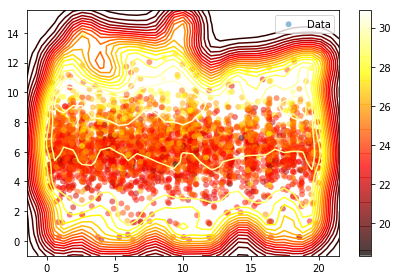

In [15]:
m2 = GPy.models.GPRegression(x,y,kernel=k.copy())
_ = m2.plot()
plt.colorbar(mappable)

In [19]:
num_points=100
xmin,xmax = -1,21
ymin,ymax = -1,15
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, num_points), np.linspace(ymin, ymax, num_points))
grid = np.hstack((grid_x.reshape(-1,1),grid_y.reshape(-1,1)))
norm = matplotlib.colors.Normalize(vmin=17,vmax=32)

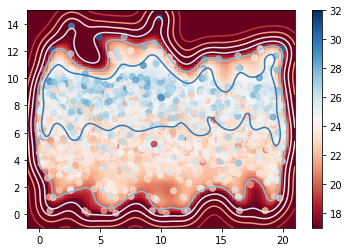

In [20]:
z = m2.predict(grid)[0].reshape(grid_x.shape)
fig, ax = plt.subplots()
c = ax.pcolormesh(grid_x, grid_y, z, cmap=cm.RdBu, norm = norm)
ax.contour(grid_x, grid_y, z,cmap=cm.RdBu) #Non normalized values, keep that in mind
ax.scatter(x[:,0],x[:,1],c=y.squeeze(),cmap=cm.RdBu, norm = norm, alpha =0.65)
fig.colorbar(c, ax=ax)
#fig.savefig(f"{cell}/{cell}_lesslength{i}_grid.pdf")
#plt.close()

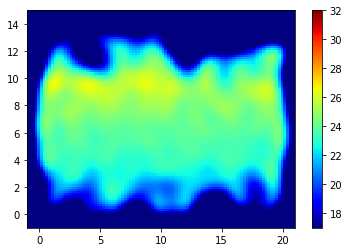

In [21]:
z = m2.predict(grid)[0].reshape(grid_x.shape)
fig, ax = plt.subplots()
c = ax.pcolormesh(grid_x, grid_y, z, cmap=cm.jet, norm = norm)
#ax.contour(grid_x, grid_y, z,cmap=cm.RdBu) #Non normalized values, keep that in mind
#ax.scatter(x[:,0],x[:,1],c=y.squeeze(),cmap=cm.jet, norm = norm, alpha =0.65)
fig.colorbar(c, ax=ax)
#fig.savefig(f"{cell}/{cell}_lesslength{i}_grid.pdf")
#plt.close()

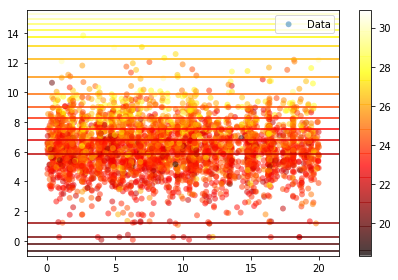

In [14]:
m2.optimize(messages=1, ipython_notebook=True)
_ = m2.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)